In [8]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [14]:
def p_analytical(x, y):
    X, Y = numpy.meshgrid(x,y)
    
    p_an = numpy.sinh(1.5*numpy.pi*Y / x[-1]) /\
    (numpy.sinh(1.5*numpy.pi*y[-1]/x[-1]))*numpy.sin(1.5*numpy.pi*X/x[-1])
    
    return p_an

In [15]:
nx = 41
ny = 41

x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

p_an = p_analytical(x,y)

In [33]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

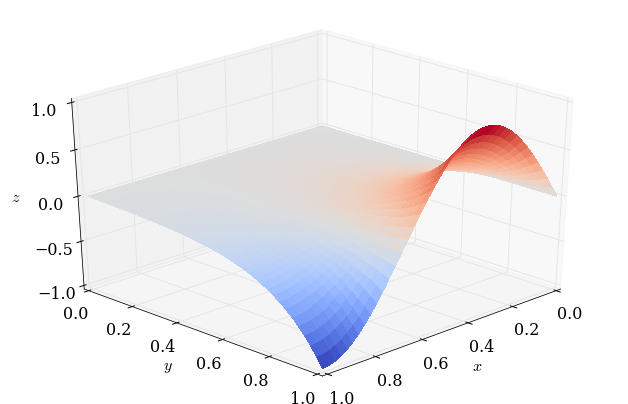

In [34]:
plot_3D(x,y,p_an)

In [35]:
def L2_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))


In [36]:
def laplace2d(p, y, dx, dy, l2_target):
    '''Iteratively solves the Laplace equation using the Jacobi method
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    y: array of float
        Nodal coordinates in y
    dx: float
        Mesh size
    dy: float
        Mesh size
    l2_target: float
        Error target
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##Neumann B.C. along x = L
        p[1:-1, -1] = p[1:-1, -2]
        l2norm = L2_error(p, pn)
     
    return p

In [37]:
##variable declarations
nx = 41
ny = 41
dx = 1/(nx-1)
dy = 1/(ny-1)


##initial conditions
p = numpy.zeros((ny,nx)) ##create a XxY vector of 0's


##plotting aids
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

##Dirichlet boundary conditions
p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])

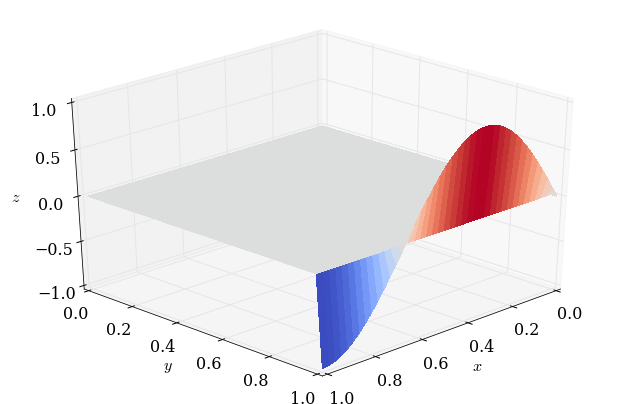

In [38]:
plot_3D(x, y, p)

In [39]:
p = laplace2d(p.copy(), y, dx, dy,1e-8)

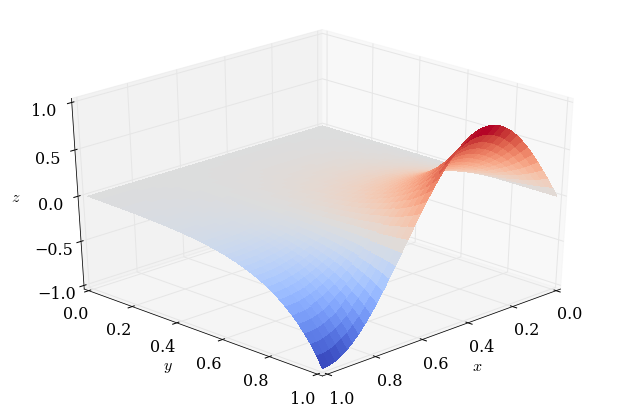

In [40]:
plot_3D(x,y,p)

In [41]:
def laplace_IG(nx):
    '''Generates initial conditions for Laplace 2D problem for a 
    given number of grid points (nx) within the domain [0,1]x[0,1]
    
    Parameters:
    ----------
    nx: int
        number of grid points in x (and implicitly y) direction
        
    Returns:
    -------
    p: 2D array of float
        Pressure distribution after relaxation
    x: array of float
        linspace coordinates in x
    y: array of float
        linspace coordinates in y
    dx: float
        grid spacing in x
    dy: float
        grid spacing in y
    '''
    dx = 1/(nx-1)

    ##initial conditions
    p = numpy.zeros((nx,nx)) ##create a XxY vector of 0's

    ##plotting aids
    x = numpy.linspace(0,1,nx)
    y = x
    dy = dx

    ##Dirichlet boundary conditions
    p[:,0] = 0
    p[0,:] = 0
    p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])
    
    return p, x, y, dx, dy


In [42]:
nx_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y, dx, dy = laplace_IG(nx)
    
    p = laplace2d(p.copy(), y, dx, dy, l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)

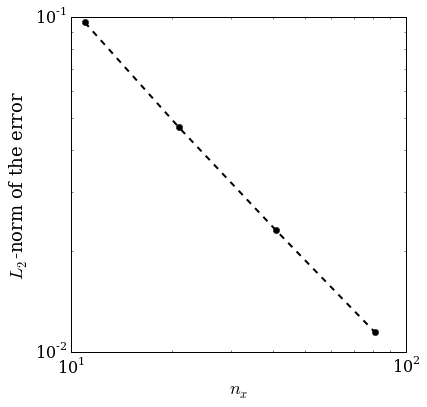

In [43]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

In [44]:
def laplace2d_neumann(p, y, dx, dy, l2_target):
    '''Solves the diffusion equation with forward-time, centered scheme
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    y: array of float
        Nodal coordinates in y
    dx: float
        Mesh size
    dy: float
        Mesh size
    l2_target: float
        Error target
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##2nd-order Neumann B.C. along x = L
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:, -1] + pn[:-2, -1])
        
        l2norm = L2_error(p, pn)
     
    return p

In [45]:
x_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y, dx, dy = laplace_IG(nx)
    
    p = laplace2d_neumann(p.copy(), y, dx, dy, l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)

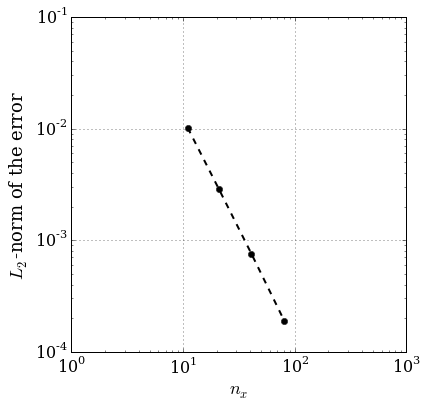

In [46]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');